**MNIST**

*Preparation*

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
import time
import pandas as pd
from torchvision import datasets, transforms


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_loader(train, batch_size):
    '''Cкачает мнист и сохранит где-то рядом.'''
    

    dataset = datasets.MNIST('mnist', train=train, download=True,
        transform=transforms.ToTensor())
    

    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return loader
    
train = get_loader(True, 95)
val = get_loader(False, 95)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [3]:
#Accuracy
def accuracy(model, val):
    total = 0
    correct = 0
    for X, y in val:
        X = X.view(-1, 784)
        res = model(X)
        res = res.argmax(dim=1)
        total += res.shape[0]
        correct += (res == y).sum().item()
    return correct / total

*Architecture*

In [ ]:
#Архитектура нейронной сети.
model = nn.Sequential(
    #layer 1
    nn.Linear(28 * 28, 532),
    nn.Tanh(),
    nn.Dropout(0.2),

    #layer 2
    nn.Linear(532, 10),

    #layer 3
    nn.LogSoftmax(dim=1)
  ) 
  #Fit
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2/5)
criterion = nn.NLLLoss()
train_losses = []
acr = []
grad = []
for epoch in range(10):
  grad_one_epoch = []
  for X, y in train:
        model.train()
        X = X.view(-1, 784)
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        g = nn.utils.clip_grad_norm_(model.parameters(), float('inf'))
        grad_one_epoch.append(g.item())
        train_losses.append(loss.item())
        optimizer.step()
  model.eval()
  accuracy_one_epoch = accuracy(model, val)
  acr.append(accuracy_one_epoch)
  grad.append(grad_one_epoch)
  print(f"epoch: {epoch}, train: {accuracy(model, train)}, test: {accuracy_one_epoch}")
print(f"mean accuracy: {sum(acr)/len(acr)}")

epoch: 0, train: 0.955, test: 0.9518
epoch: 1, train: 0.9750333333333333, test: 0.9687
epoch: 2, train: 0.979, test: 0.9684
epoch: 3, train: 0.9859, test: 0.9733
epoch: 4, train: 0.9865, test: 0.9716
epoch: 5, train: 0.9914833333333334, test: 0.9772
epoch: 6, train: 0.9906666666666667, test: 0.9748
epoch: 7, train: 0.99065, test: 0.9762
epoch: 8, train: 0.9943166666666666, test: 0.9796
epoch: 9, train: 0.9945333333333334, test: 0.9778
mean accuracy: 0.97194


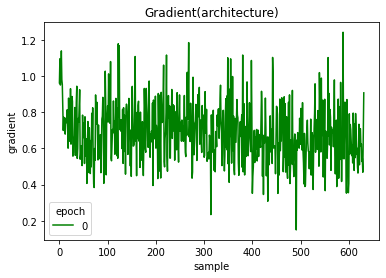

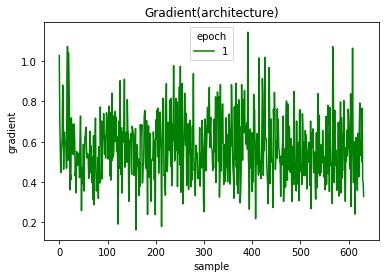

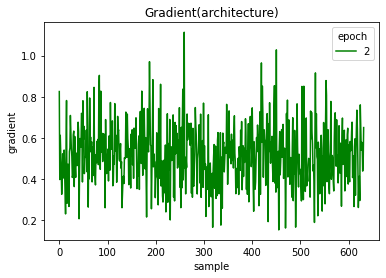

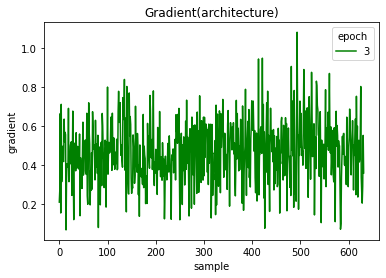

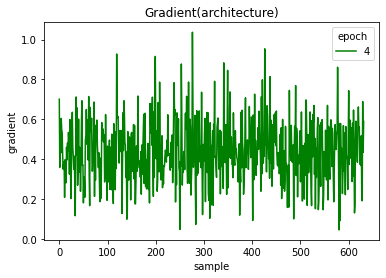

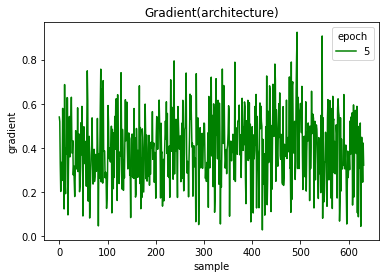

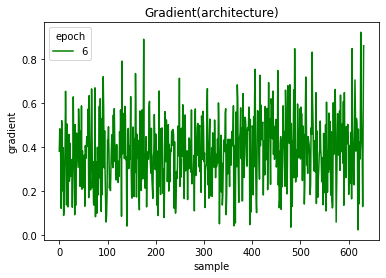

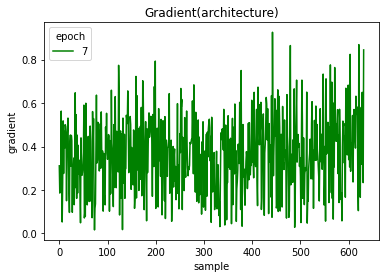

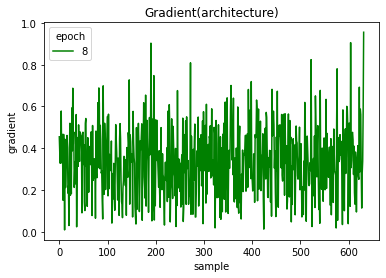

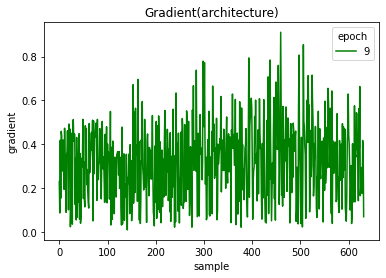

In [ ]:
#Визуализируем модуль среднего градиента. 
x = [i for i in range(len(train))]
for i in range(len(grad)):
  plt.plot(x, grad[i], color = 'green', label=f"{i}")
  plt.title(f"Gradient(architecture)")
  plt.xlabel("sample")
  plt.ylabel("gradient")
  plt.legend(title="epoch")
  plt.show()

In [ ]:
#Несмотря на то, что у модели Adam присутствует эвристика, которая защищает от взрыва градиента,  дополнительно ограничим градиент с помощью clipping value, т.е не дадим сети 
#делать "резкие" шаги по лосс лэндскейпу. Это поможет избежать ситуации, когда сеть уверенна в неправильном ответе и из-за этого идет большими шагами в неправильном направлении. 
model = nn.Sequential(
    #layer 1
    nn.Linear(28 * 28, 532),
    nn.Tanh(),
    nn.Dropout(0.2),

    #layer 3
    nn.Linear(532, 10),

    #layer 4
    nn.LogSoftmax(dim=1)
  ) 
  #Fit
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2/5)
criterion = nn.NLLLoss()
train_losses = []
grad = []
acr = []
threshold = float("inf")
for epoch in range(10):
  grad_one_epoch = []
  for X, y in train:
        model.train()
        X = X.view(-1, 784)
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), threshold)
        g = nn.utils.clip_grad_norm_(model.parameters(), float("inf"))
        grad_one_epoch.append(g.item())
        train_losses.append(loss.item())
        optimizer.step()
  model.eval()
  threshold = np.quantile(np.array(grad_one_epoch), 0.99)
  accuracy_one_epoch = accuracy(model, val)
  acr.append(accuracy_one_epoch)
  grad.append(grad_one_epoch)
  print(f"epoch: {epoch}, train: {accuracy(model, train)}, test: {accuracy_one_epoch}")
print(f"mean accuracy: {sum(acr)/len(acr)}")

epoch: 0, train: 0.9555333333333333, test: 0.9553
epoch: 1, train: 0.9719833333333333, test: 0.9658
epoch: 2, train: 0.9805666666666667, test: 0.9705
epoch: 3, train: 0.986, test: 0.9733
epoch: 4, train: 0.9895333333333334, test: 0.979
epoch: 5, train: 0.9920666666666667, test: 0.9774
epoch: 6, train: 0.9936166666666667, test: 0.9789
epoch: 7, train: 0.99395, test: 0.9771
epoch: 8, train: 0.9945833333333334, test: 0.98
epoch: 9, train: 0.9933166666666666, test: 0.9771
mean accuracy: 0.9734400000000001


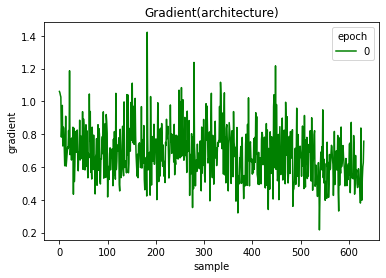

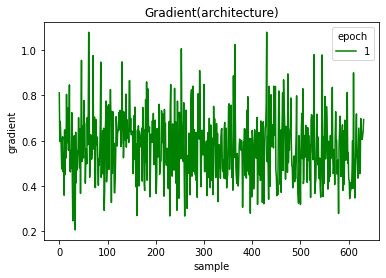

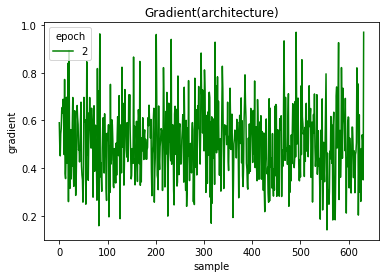

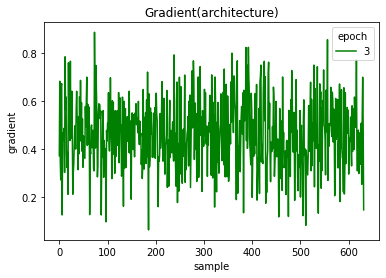

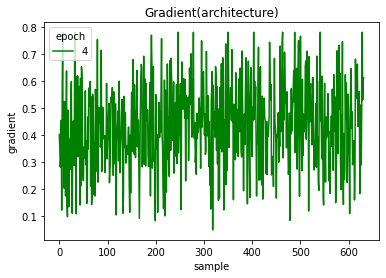

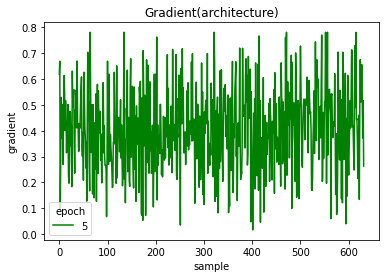

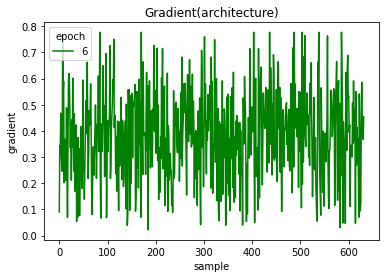

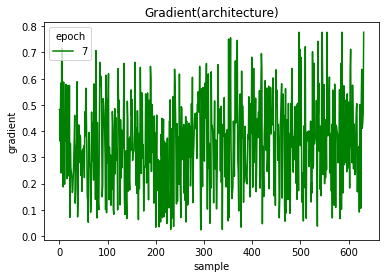

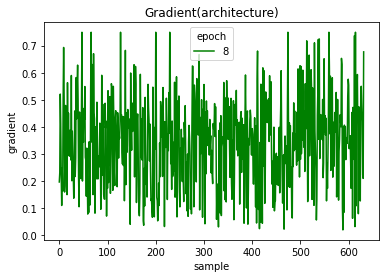

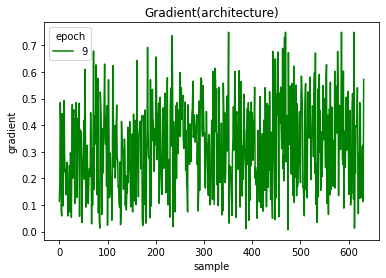

In [ ]:
#Визуализируем модуль среднего градиента. 
x = [i for i in range(len(train))]
for i in range(len(grad)):
  plt.plot(x, grad[i], color = 'green', label=f"{i}")
  plt.title(f"Gradient(architecture)")
  plt.xlabel("sample")
  plt.ylabel("gradient")
  plt.legend(title="epoch")
  plt.show()

In [ ]:
#Цель была достигнута:пиковое значение метрики немного увеличилось (0.9796 -> 0.98). Можно заметить, что среднее значение метрики значительно увеличилось. Объяснить это можно тем, 
#что сеть аккуратнее делала шаги => если сеть хотела уйти из какого минимума, то она из него медленее уходила и также сам этот минимум она находила более аккуратно, чем предыдущая
#конфигурация.

*Hyperparametrs*

In [ ]:
#Для улучшения полученного результата попробуем найти оптимальную скорость обучения. 

In [ ]:
#Найдем лучшую скорость обучения в первом приближении.
speed = [1e-4, 1e-4 * 3, 1e-4 * 7, 1e-3, 1e-3 * 3, 1e-3 * 7, 1e-2]
id = [i for i in range(10)]
acr = []
grad = []
for s in speed:
  print(f"learning rate {s}:")
  #Model
  model = nn.Sequential(
    #layer 1
    nn.Linear(28 * 28, 532),
    nn.Tanh(),
    nn.Dropout(0.2),

    #layer 3
    nn.Linear(532, 10),

    #layer 4
    nn.LogSoftmax(dim=1)
  ) 
  #Fit
  optimizer = torch.optim.Adam(model.parameters(), lr=s)
  criterion = nn.NLLLoss()
  train_losses = []
  grad_one_iter = []
  acr_one_iter = []
  treshold = float("inf")
  for epoch in range(10):
    grad_one_epoch = []
    for X, y in train:
          model.train()
          X = X.view(-1, 784)
          optimizer.zero_grad()
          output = model(X)
          loss = criterion(output, y)
          loss.backward()
          nn.utils.clip_grad_norm_(model.parameters(), treshold)
          g = nn.utils.clip_grad_norm_(model.parameters(), float("inf"))
          grad_one_epoch.append(g.item())
          train_losses.append(loss.item())
          optimizer.step()
    model.eval()
    threshold = np.quantile(np.array(grad_one_epoch), 0.99)
    accuracy_one_epoch = accuracy(model, val)
    acr_one_iter.append(accuracy_one_epoch)
    grad_one_iter.append(grad_one_epoch)
    print(f"epoch: {epoch}, train: {accuracy(model, train)}, test: {accuracy_one_epoch}")
  print(f"mean accuracy: {sum(acr_one_iter)/len(acr_one_iter)}")
  grad.append(grad_one_iter)
  acr.append(acr_one_iter)
  print()


learning rate 0.0001:
epoch: 0, train: 0.8973666666666666, test: 0.9028
epoch: 1, train: 0.9120666666666667, test: 0.9149
epoch: 2, train: 0.9207333333333333, test: 0.9209
epoch: 3, train: 0.9259333333333334, test: 0.9261
epoch: 4, train: 0.9296166666666666, test: 0.9279
epoch: 5, train: 0.9337, test: 0.9337
epoch: 6, train: 0.93815, test: 0.9369
epoch: 7, train: 0.9419, test: 0.9405
epoch: 8, train: 0.9452, test: 0.9416
epoch: 9, train: 0.94885, test: 0.945
mean accuracy: 0.92903

learning rate 0.00030000000000000003:
epoch: 0, train: 0.9182666666666667, test: 0.9184
epoch: 1, train: 0.93255, test: 0.932
epoch: 2, train: 0.9440333333333333, test: 0.9417
epoch: 3, train: 0.9501166666666667, test: 0.9457
epoch: 4, train: 0.9591166666666666, test: 0.9538
epoch: 5, train: 0.96415, test: 0.9592
epoch: 6, train: 0.96845, test: 0.9612
epoch: 7, train: 0.9719, test: 0.9629
epoch: 8, train: 0.9757833333333333, test: 0.967
epoch: 9, train: 0.9788333333333333, test: 0.9697
mean accuracy: 0.95116

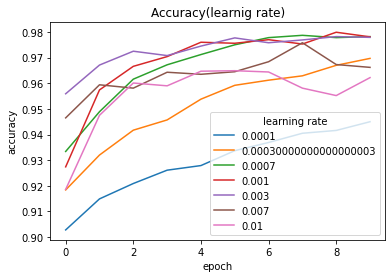

In [ ]:
#Визуализируем зависимость метрики от различного значения скорости обучения.
for i in range(len(acr)):
  plt.plot(id, acr[i], label=str(speed[i]))
  plt.legend(title='learning rate')
plt.title('Accuracy(learnig rate)')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

In [ ]:
#Очевидно, что нужно искать оптимальное значение скорости обучения на отрезке [0.0007 0.003].

In [ ]:
#Найдем лучшую скорость обучения во втором приближении.
speed = [0.0007, 0.0008, 0.0009, 0.001, 0.002, 0.003]
id = [i for i in range(10)]
acr = []
grad = []
for s in speed:
  print(f"learning rate {s}:")
  #Model
  model = nn.Sequential(
    #layer 1
    nn.Linear(28 * 28, 532),
    nn.Tanh(),
    nn.Dropout(0.2),

    #layer 3
    nn.Linear(532, 10),

    #layer 4
    nn.LogSoftmax(dim=1)
  ) 
  #Fit
  optimizer = torch.optim.Adam(model.parameters(), lr=s)
  criterion = nn.NLLLoss()
  train_losses = []
  grad_one_iter = []
  acr_one_iter = []
  treshold = float("inf")
  for epoch in range(10):
    grad_one_epoch = []
    for X, y in train:
          model.train()
          X = X.view(-1, 784)
          optimizer.zero_grad()
          output = model(X)
          loss = criterion(output, y)
          loss.backward()
          nn.utils.clip_grad_norm_(model.parameters(), treshold)
          g = nn.utils.clip_grad_norm_(model.parameters(), float("inf"))
          grad_one_epoch.append(g.item())
          train_losses.append(loss.item())
          optimizer.step()
    model.eval()
    threshold = np.quantile(np.array(grad_one_epoch), 0.99)
    accuracy_one_epoch = accuracy(model, val)
    acr_one_iter.append(accuracy_one_epoch)
    grad_one_iter.append(grad_one_epoch)
    print(f"epoch: {epoch}, train: {accuracy(model, train)}, test: {accuracy_one_epoch}")
  print(f"mean accuracy: {sum(acr_one_iter)/len(acr_one_iter)}")
  grad.append(grad_one_iter)
  acr.append(acr_one_iter)
  print()

learning rate 0.0007:
epoch: 0, train: 0.92655, test: 0.9238
epoch: 1, train: 0.9501833333333334, test: 0.9465
epoch: 2, train: 0.96355, test: 0.9596
epoch: 3, train: 0.9733, test: 0.9657
epoch: 4, train: 0.9792666666666666, test: 0.9725
epoch: 5, train: 0.98205, test: 0.9724
epoch: 6, train: 0.9837666666666667, test: 0.9739
epoch: 7, train: 0.9878, test: 0.9768
epoch: 8, train: 0.9897666666666667, test: 0.9774
epoch: 9, train: 0.99215, test: 0.9799
mean accuracy: 0.96485

learning rate 0.0008:
epoch: 0, train: 0.9347833333333333, test: 0.9323
epoch: 1, train: 0.95605, test: 0.9518
epoch: 2, train: 0.9690833333333333, test: 0.9632
epoch: 3, train: 0.9758, test: 0.9678
epoch: 4, train: 0.98135, test: 0.972
epoch: 5, train: 0.9818666666666667, test: 0.9722
epoch: 6, train: 0.9885833333333334, test: 0.9784
epoch: 7, train: 0.98975, test: 0.9774
epoch: 8, train: 0.9901166666666666, test: 0.9771
epoch: 9, train: 0.9930666666666667, test: 0.9784
mean accuracy: 0.96706

learning rate 0.0009:


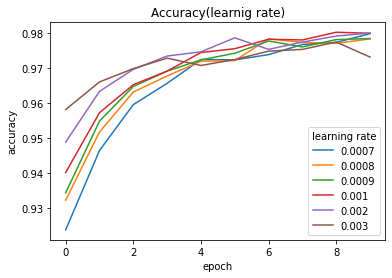

In [ ]:
#Визуализируем зависимость метрики от различного значения скорости обучения.
for i in range(len(acr)):
  plt.plot(id, acr[i], label=str(speed[i]))
  plt.legend(title='learning rate')
plt.title('Accuracy(learnig rate)')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

In [ ]:
#После визуализации мы получаем ожидаемый результат. Сети с меньшей скоростью обучения набирают скор более стабильно, но при этом их пик может и не быть очень высоким, а сети
#с большей скоростью обучения набирают скор очень резко и также резко его теряют(выпрыгивают из локального/глобального минимума). Таким образом, оптимальное значение lr = 0.001.

Best accuracy(validation): 0.9803

**Morphing**

*Preparation*

In [4]:
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

In [5]:
#Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, encode, decode):
        super().__init__()
        
        self.encode = encode
        self.decode = decode
    
    def forward(self, x):
        return self.decode(self.encode(x))

In [6]:
encode = []
decode = []
model1 = Autoencoder(encode, decode)

In [7]:
def get(x):
    return train.dataset[x][0].view(1, 784)

def imshow(img):
    pic = img.numpy().astype('float')
    plt.axis('off')
    return plt.imshow(pic, cmap='Greys', animated=True)

def morph(inputs, steps, delay, model_):
    # перегоняем в латентное пространство все картинки на входе
    latent = [model_.encode(get(k)).data for k in inputs]
    fig = plt.figure()
    images = []
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in np.linspace(0, 1, steps):
            c = a*(1-t)+b*t
            morphed = model_.decode(c).data
            morphed = morphed.view(28, 28)
            images.append([imshow(morphed)])
    
    ani = animation.ArtistAnimation(fig, images, interval=delay)
    display(HTML(ani.to_html5_video()))

*Architecture*

In [ ]:
#Architecture
encode = nn.Sequential(
            nn.Linear(28 * 28, 394),
            nn.LeakyReLU(),
      
            nn.Linear(394, 10),
        )

decode = nn.Sequential(
            nn.LeakyReLU(),
            nn.Linear(10, 394),

            nn.LeakyReLU(), 
            nn.Linear(394, 28 * 28),
           
            nn.Sigmoid()
        )

In [ ]:
#Fitting 
model1 = Autoencoder(encode, decode)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters())
for epoch in range(10):
    train_loss = 0
    for data, _ in train:
        data = data.view(-1, 784)
        
        optimizer.zero_grad()
        
        reconstructed = model1(data)
        loss = criterion(data, reconstructed)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()
    print(f"epoch: {epoch}, loss: {train_loss / len(train)}")

epoch: 0, loss: 0.03899791865326653
epoch: 1, loss: 0.02423833803969282
epoch: 2, loss: 0.02120681757791133
epoch: 3, loss: 0.019734081479166693
epoch: 4, loss: 0.01879784617060206
epoch: 5, loss: 0.018134942883920348
epoch: 6, loss: 0.017621169273470398
epoch: 7, loss: 0.017186242101207092
epoch: 8, loss: 0.016750203074203638
epoch: 9, loss: 0.016171076930352028


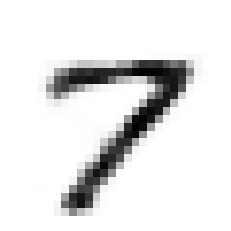

In [ ]:
#Visualization
morph(np.random.randint(0, len(train.dataset), 30), 22, 35, model1)

In [ ]:
#Update
encode = nn.Sequential(
            nn.Linear(28 * 28, 392),
            nn.LeakyReLU(),
      
            nn.Linear(392, 196),
            nn.LeakyReLU(),

            nn.Linear(196, 10),
        )

decode = nn.Sequential(
            nn.LeakyReLU(),
            nn.Linear(10, 196),

            nn.LeakyReLU(),
            nn.Linear(196, 392),

            nn.LeakyReLU(), 
            nn.Linear(392, 28 * 28),
           
            nn.Sigmoid()
        )

In [ ]:
#Fitting 
model2 = Autoencoder(encode, decode)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters())
for epoch in range(10):
    train_loss = 0
    for data, _ in train:
        data = data.view(-1, 784)
        
        optimizer.zero_grad()
        
        reconstructed = model2(data)
        loss = criterion(data, reconstructed)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()
    print(f"epoch: {epoch}, loss: {train_loss / len(train)}")

epoch: 0, loss: 0.04359337690734316
epoch: 1, loss: 0.024251335312294054
epoch: 2, loss: 0.020755326664193146
epoch: 3, loss: 0.019087388448393607
epoch: 4, loss: 0.01810075537908728
epoch: 5, loss: 0.017362613034953327
epoch: 6, loss: 0.01676827731919534
epoch: 7, loss: 0.016252209765459352
epoch: 8, loss: 0.01566889185069388
epoch: 9, loss: 0.015093192433101373


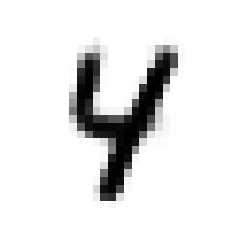

In [ ]:
#Visualization
morph(np.random.randint(0, len(train.dataset), 30), 22, 35, model2)

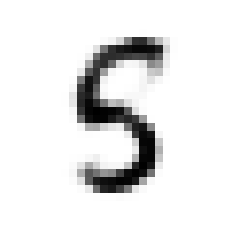

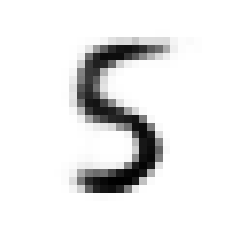

In [ ]:
#Model1 vs Model2
test = np.random.randint(0, len(train.dataset), 30)
morph(test, 22, 35, model1)
time.sleep(7.5)
morph(test, 22, 35, model2)

In [ ]:
#Update
encode = nn.Sequential(
            nn.Linear(28 * 28, 392),
            nn.LeakyReLU(),
      
            nn.Linear(392, 196),
            nn.LeakyReLU(),

            nn.Linear(196, 98),
            nn.LeakyReLU(),

            nn.Linear(98, 10),
        )

decode = nn.Sequential(
            nn.LeakyReLU(),
            nn.Linear(10, 98),

            nn.LeakyReLU(),
            nn.Linear(98, 196),

            nn.LeakyReLU(),
            nn.Linear(196, 392),

            nn.LeakyReLU(), 
            nn.Linear(392, 28 * 28),
           
            nn.Sigmoid()
        )

In [ ]:
#Fitting 
model3 = Autoencoder(encode, decode)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model3.parameters())
for epoch in range(10):
    train_loss = 0
    for data, _ in train:
        data = data.view(-1, 784)
        
        optimizer.zero_grad()
        
        reconstructed = model3(data)
        loss = criterion(data, reconstructed)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()
    print(f"epoch: {epoch}, loss: {train_loss / len(train)}")

epoch: 0, loss: 0.048618291472261654
epoch: 1, loss: 0.027046981700872885
epoch: 2, loss: 0.024140390983040008
epoch: 3, loss: 0.021764002103782907
epoch: 4, loss: 0.020249118533315538
epoch: 5, loss: 0.01929683170776484
epoch: 6, loss: 0.01858992063841205
epoch: 7, loss: 0.018001988457952024
epoch: 8, loss: 0.017537077871163056
epoch: 9, loss: 0.017181783681735396


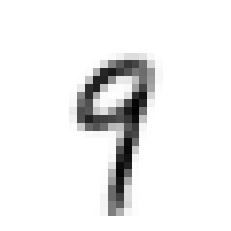

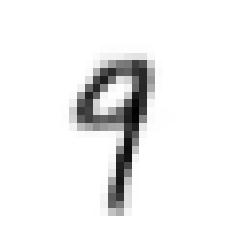

In [ ]:
#Model2 vs Model3
test = np.random.randint(0, len(train.dataset), 30)
morph(test, 22, 35, model2)
time.sleep(7.5)
morph(test, 22, 35, model3)

In [ ]:
#Лосс ухудшился => вернемся к прошлой конфигурации модели и попробуем изменить гиперпараметры функции активации.

In [ ]:
#Update
encode = nn.Sequential(
            nn.Linear(28 * 28, 392),
            nn.LeakyReLU(0.09),
      
            nn.Linear(392, 196),
            nn.LeakyReLU(0.09),

            nn.Linear(196, 10),
        )

decode = nn.Sequential(
            nn.LeakyReLU(0.09),
            nn.Linear(10, 196),

            nn.LeakyReLU(0.09),
            nn.Linear(196, 392),

            nn.LeakyReLU(0.09), 
            nn.Linear(392, 28 * 28),
           
            nn.Sigmoid()
        )

In [ ]:
#Fitting 
model4 = Autoencoder(encode, decode)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model4.parameters())
for epoch in range(10):
    train_loss = 0
    for data, _ in train:
        data = data.view(-1, 784)
        
        optimizer.zero_grad()
        
        reconstructed = model4(data)
        loss = criterion(data, reconstructed)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()
    print(f"epoch: {epoch}, loss: {train_loss / len(train)}")

epoch: 0, loss: 0.04418579623091353
epoch: 1, loss: 0.02465000626619292
epoch: 2, loss: 0.02068351244530346
epoch: 3, loss: 0.018265836490495013
epoch: 4, loss: 0.017004255662212454
epoch: 5, loss: 0.015892771121314903
epoch: 6, loss: 0.015072730458282594
epoch: 7, loss: 0.014484799159042348
epoch: 8, loss: 0.013995002831414909
epoch: 9, loss: 0.013633074682453483


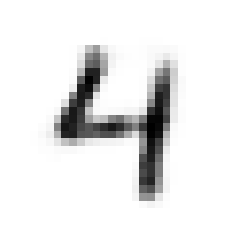

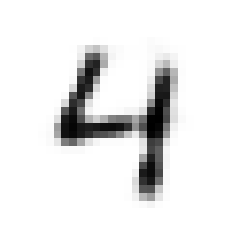

In [ ]:
#Model3 vs Model4
test = np.random.randint(0, len(train.dataset), 30)
morph(test, 22, 35, model3)
time.sleep(7.5)
morph(test, 22, 35, model4)

In [ ]:
#Лосс улучшился, зафиксируем его как лучший.
model_best = model4

In [ ]:
#Best architecture
encode = nn.Sequential(
            nn.Linear(28 * 28, 392),
            nn.LeakyReLU(0.09),
      
            nn.Linear(392, 196),
            nn.LeakyReLU(0.09),

            nn.Linear(196, 10),
        )

decode = nn.Sequential(
            nn.LeakyReLU(0.09),
            nn.Linear(10, 196),

            nn.LeakyReLU(0.09),
            nn.Linear(196, 392),

            nn.LeakyReLU(0.09), 
            nn.Linear(392, 28 * 28),
           
            nn.Sigmoid()
        )

Best MSE(validation): 0.013633074682453483

In [ ]:
#Посмотрим на результаты модели на лоссе MAE.
model_bonus = Autoencoder(encode, decode)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model_bonus.parameters())
for epoch in range(10):
    train_loss = 0
    for data, _ in train:
        data = data.view(-1, 784)
        
        optimizer.zero_grad()
        
        reconstructed = model_bonus(data)
        loss = criterion(data, reconstructed)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()
    print(f"epoch: {epoch}, loss: {train_loss / len(train)}")

epoch: 0, loss: 0.11943845019404646
epoch: 1, loss: 0.0685061660500927
epoch: 2, loss: 0.055491741381208354
epoch: 3, loss: 0.050970992987055944
epoch: 4, loss: 0.04798410655459082
epoch: 5, loss: 0.0449264301812347
epoch: 6, loss: 0.04295850658341299
epoch: 7, loss: 0.041430215198027934
epoch: 8, loss: 0.040315570669319435
epoch: 9, loss: 0.039403313458484565


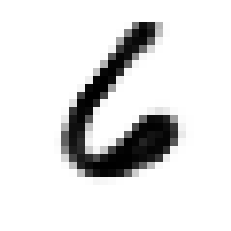

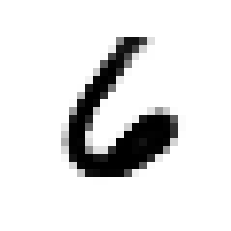

In [ ]:
#Model_MSE vs Model_MAE
test = np.random.randint(0, len(train.dataset), 30)
morph(test, 22, 35, model_best)
time.sleep(7.6)
morph(test, 22, 35, model_bonus)

In [ ]:
#Вывод

**Visualization**

In [323]:
#Architecture
encode = nn.Sequential(
            nn.Linear(784, 512),
            nn.Tanh(),

            nn.Linear(512, 256),
            nn.LeakyReLU(),

            nn.Linear(256, 128),
            nn.LeakyReLU(),

            nn.Linear(128, 64),
            nn.LeakyReLU(),

            nn.Linear(64, 32),
            nn.LeakyReLU(),

            nn.Linear(32, 16),
            nn.Sigmoid(),

            nn.Linear(16, 2),

        )

decode = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),

            nn.Linear(16, 32),
            nn.ReLU(),

            nn.Linear(32, 64),
            nn.ReLU(),

            nn.Linear(64, 128),
            nn.ReLU(),

            nn.Linear(128, 256),
            nn.ReLU(),

            nn.Linear(256, 512),
            nn.ReLU(),

            nn.Linear(512, 28 * 28),

            nn.Sigmoid(),

        )

In [324]:
#Fitting 
model = Autoencoder(encode, decode)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
threshold = float("inf")
for epoch in range(12):
    train_loss = 0
    for data, _ in train:
        model.train()
        grad_one_epoch=[]
        data = data.view(-1, 784)
        
        optimizer.zero_grad()
        
        reconstructed = model(data)
        loss = criterion(data, reconstructed)
        
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), threshold)
        g = nn.utils.clip_grad_norm_(model.parameters(), float("inf"))
        grad_one_epoch.append(g.item())

        train_loss += loss.item()
        optimizer.step()
    threshold = np.quantile(np.array(grad_one_epoch), 0.99)
    print(f"epoch: {epoch}, loss: {train_loss / len(train)}")

epoch: 0, loss: 0.06258972194871004
epoch: 1, loss: 0.05365020007814599
epoch: 2, loss: 0.04940546362342525
epoch: 3, loss: 0.04663955269357826
epoch: 4, loss: 0.04451874576956977
epoch: 5, loss: 0.043225342826328325
epoch: 6, loss: 0.04226642027143625
epoch: 7, loss: 0.04136951824155035
epoch: 8, loss: 0.04103133261581011
epoch: 9, loss: 0.041087592798697795
epoch: 10, loss: 0.03987075915984527
epoch: 11, loss: 0.039595005509172436


In [325]:
#Preparation
dataset = datasets.MNIST('mnist', train=train, download=True,
        transform=transforms.ToTensor())
latent = [model.encode(get(k)).data for k in range (dataset.data.shape[0])]
latent = np.array(list(map(lambda x: x.tolist()[0], latent)))
target = np.array(list(map(lambda x: x.item(), dataset.targets)))
dataset = pd.DataFrame(np.hstack((latent, target.reshape(-1, 1))), columns = ["Score 1", "Score 2", "Digit"])
group = dataset.groupby(by = ['Digit'])

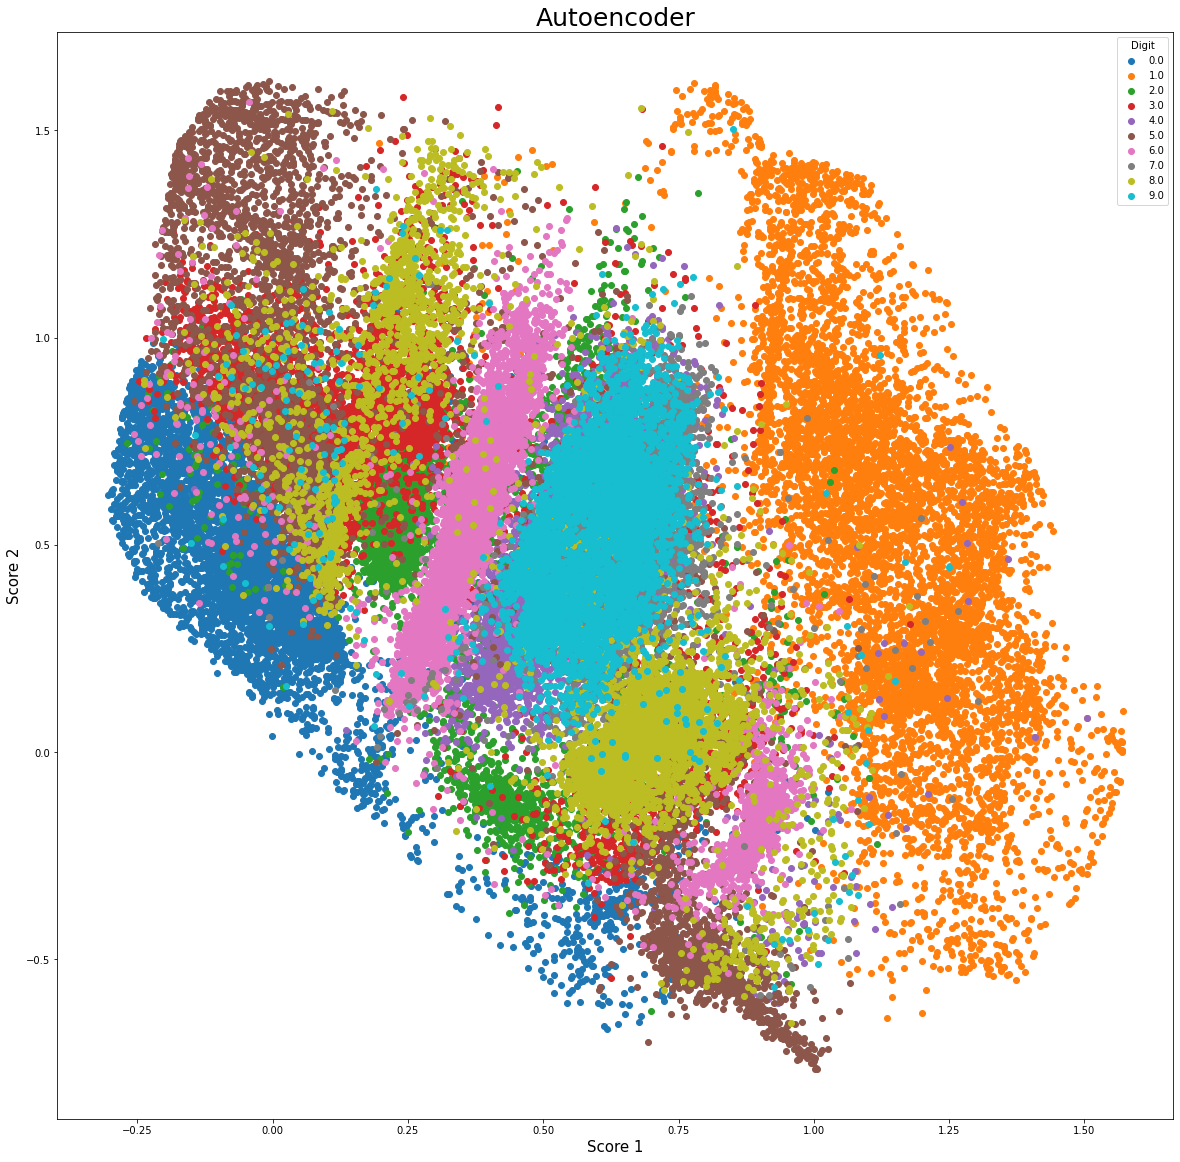

In [329]:
#Visualization
for key, item in group:
  plt.figure(num=1, figsize = (20, 20))
  plt.scatter(group.get_group(key)['Score 1'], group.get_group(key)['Score 2'], label = key)
plt.legend(title='Digit')
plt.title('Autoencoder', fontdict = {'fontsize' : 25})
plt.xlabel("Score 1", fontdict = {'fontsize' : 15})
plt.ylabel("Score 2", fontdict = {'fontsize' : 15})
plt.show()